In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dataset/dataset/Cicero/FB_IMG_1564490982648.jpg
/kaggle/input/dataset/dataset/Cicero/IMG_20180331_220900066.jpg
/kaggle/input/dataset/dataset/Cicero/20230408_143113.jpg
/kaggle/input/dataset/dataset/Cicero/20241223_115936.jpg
/kaggle/input/dataset/dataset/Cicero/20250316_020402.jpg
/kaggle/input/dataset/dataset/Cicero/20200308_152855.jpg
/kaggle/input/dataset/dataset/Cicero/20241223_114558.jpg
/kaggle/input/dataset/dataset/Cicero/Screenshot_20221224_183938.jpg
/kaggle/input/dataset/dataset/Cicero/20210309_204639.jpg
/kaggle/input/dataset/dataset/Cicero/20210309_205228.jpg
/kaggle/input/dataset/dataset/Cicero/20241222_155742.jpg
/kaggle/input/dataset/dataset/Cicero/20201012_143617.jpg
/kaggle/input/dataset/dataset/Cicero/IMG-20220929-WA0013.jpg
/kaggle/input/dataset/dataset/Cicero/20210309_205204.jpg
/kaggle/input/dataset/dataset/Cicero/20241222_151500.jpg
/kaggle/input/dataset/dataset/Cicero/20210309_205324.jpg
/kaggle/input/dataset/dataset/Cicero/20190602_183300.jpg
/kag

In [2]:
# Instala as bibliotecas necessárias
!pip install mtcnn

# Importa as bibliotecas
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from PIL import Image

print("Bibliotecas importadas com sucesso!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 23.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.1 MB/s eta 0:00:00


2025-08-22 19:12:09.519077: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755889929.901322      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755889930.007740      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Bibliotecas importadas com sucesso!


In [3]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0

# Carrega o modelo EfficientNetV2B0 pré-treinado no ImageNet
# weights='imagenet': Usa os pesos aprendidos no ImageNet.
# include_top=False: REMOVE a camada final de classificação (as 1000 classes do ImageNet). É ESSENCIAL para extração de características.
# pooling='avg': Adiciona uma camada de Global Average Pooling no final. Isso transforma a saída 2D do modelo em um vetor 1D (nosso embedding).
# input_shape=(224, 224, 3): Define o tamanho da imagem de entrada.

INPUT_SIZE = 224
model_embedding = EfficientNetV2B0(weights='imagenet', 
                                   include_top=False, 
                                   pooling='avg', 
                                   input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

print("Modelo EfficientNetV2B0 carregado com sucesso!")
model_embedding.trainable = False # Opcional, mas boa prática: congela os pesos do modelo.

I0000 00:00:1755889949.376173      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755889949.376887      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Modelo EfficientNetV2B0 carregado com sucesso!


In [4]:
# ===================================================================
#      CÉLULA COMPLETA: PREPARAÇÃO DE DADOS
# ===================================================================
# Modelo: EfficientNetV2 |

# --- 1. Importações e Definições ---
import os
import cv2
import numpy as np
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from PIL import Image
import warnings

# Ignora avisos menos importantes da biblioteca
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')


# --- 2. Carregar Modelos ---
print("Carregando modelos...")
# Detector de faces
detector = MTCNN()

# Modelo de Embedding (EfficientNetV2B0)
INPUT_SIZE = 224
model_embedding = EfficientNetV2B0(weights='imagenet', 
                                   include_top=False, 
                                   pooling='avg', 
                                   input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
model_embedding.trainable = False # Congela os pesos do modelo
print("Modelos MTCNN e EfficientNetV2B0 carregados com sucesso.")


# --- 3. Função para Extrair a Face (com correção de erro) ---
def extrair_face(caminho_imagem, tamanho_alvo=(INPUT_SIZE, INPUT_SIZE)):
    """
    Detecta, extrai e redimensiona uma face de uma imagem.
    Agora inclui uma verificação para evitar erros com arquivos inválidos.
    """
    img = cv2.imread(caminho_imagem)
    
    # *** CORREÇÃO ADICIONADA AQUI ***
    # Se a imagem for None (vazia), o arquivo não pôde ser lido.
    if img is None:
        print(f"AVISO: Não foi possível ler o arquivo: {caminho_imagem}. Pulando...")
        return None
    # *** FIM DA CORREÇÃO ***

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    resultados = detector.detect_faces(img_rgb)
    
    if not resultados:
        return None
        
    x1, y1, largura, altura = resultados[0]['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + largura, y1 + altura
    face = img_rgb[y1:y2, x1:x2]
    
    imagem = Image.fromarray(face)
    imagem = imagem.resize(tamanho_alvo)
    return np.asarray(imagem)


# --- 4. Loop Principal para Processar o Dataset ---
# Lembre-se de verificar se este caminho corresponde ao seu Kaggle Dataset
DATASET_PATH = '/kaggle/input/dataset/dataset' 
embeddings = []
labels = []

print("\nIniciando extração de embeddings...")
for nome_pessoa in os.listdir(DATASET_PATH):
    caminho_pessoa = os.path.join(DATASET_PATH, nome_pessoa)
    if not os.path.isdir(caminho_pessoa):
        continue
        
    for nome_imagem in os.listdir(caminho_pessoa):
        caminho_imagem = os.path.join(caminho_pessoa, nome_imagem)
        face = extrair_face(caminho_imagem)
        
        if face is None:
            # O aviso já é impresso dentro da função extrair_face ou a face não foi detectada
            continue

        # Pré-processamento CORRETO para EfficientNetV2
        face_expandido = np.expand_dims(face.astype('float32'), axis=0)
        face_processado = preprocess_input(face_expandido)
        
        # Gera o embedding
        embedding = model_embedding.predict(face_processado, verbose=0)[0]
        
        embeddings.append(embedding)
        labels.append(nome_pessoa)
        print(f"  > Embedding gerado para: {nome_imagem}")

# --- 5. Salvar os Dados Processados ---
if len(embeddings) > 0:
    embeddings = np.asarray(embeddings)
    labels = np.asarray(labels)
    np.savez_compressed('/kaggle/working/faces_embeddings_efficientnet.npz', embeddings, labels)
    
    print("\n--- Processamento Concluído ---")
    print(f"Total de {len(embeddings)} embeddings salvos com sucesso!")
    print(f"Arquivo salvo em: '/kaggle/working/faces_embeddings_efficientnet.npz'")
    print(f"Shape do array de embeddings: {embeddings.shape}")
else:
    print("\n--- Processamento Concluído ---")
    print("AVISO: Nenhum embedding foi gerado. Verifique seu dataset e os caminhos.")

Carregando modelos...
Modelos MTCNN e EfficientNetV2B0 carregados com sucesso.

Iniciando extração de embeddings...


I0000 00:00:1755889958.694487      69 service.cc:148] XLA service 0x7e8c200045b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755889958.696078      69 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755889958.696098      69 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755889959.519278      69 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1755889964.198800      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  > Embedding gerado para: FB_IMG_1564490982648.jpg
  > Embedding gerado para: IMG_20180331_220900066.jpg
  > Embedding gerado para: 20230408_143113.jpg
  > Embedding gerado para: 20241223_115936.jpg
  > Embedding gerado para: 20250316_020402.jpg
  > Embedding gerado para: 20200308_152855.jpg
  > Embedding gerado para: 20241223_114558.jpg
  > Embedding gerado para: Screenshot_20221224_183938.jpg
  > Embedding gerado para: 20210309_204639.jpg
  > Embedding gerado para: 20210309_205228.jpg
  > Embedding gerado para: 20241222_155742.jpg
  > Embedding gerado para: 20201012_143617.jpg
  > Embedding gerado para: IMG-20220929-WA0013.jpg
  > Embedding gerado para: 20210309_205204.jpg
  > Embedding gerado para: 20241222_151500.jpg
  > Embedding gerado para: 20210309_205324.jpg
  > Embedding gerado para: 20190602_183300.jpg
  > Embedding gerado para: 20230408_110657.jpg
  > Embedding gerado para: 20241222_131531(0).jpg
  > Embedding gerado para: 20201101_153028_HDR.jpg
  > Embedding gerado para:

In [5]:
# ===================================================================
#           ETAPA 4: TREINAMENTO DO CLASSIFICADOR (SVM)
# ===================================================================

# --- 1. Importações ---
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
import joblib

print("Bibliotecas importadas com sucesso.")

# --- 2. Carregar os Dados Processados ---
try:
    caminho_dados = '/kaggle/working/faces_embeddings_efficientnet.npz'
    data = np.load(caminho_dados)
    embeddings = data['arr_0']
    labels = data['arr_1']
    print(f"Dados carregados com sucesso. Encontrados {len(embeddings)} embeddings.")
except FileNotFoundError:
    print(f"ERRO: O arquivo {caminho_dados} não foi encontrado. Execute a célula de preparação de dados primeiro.")
    # Interrompe a execução da célula se o arquivo não existir
    raise

# --- 3. Codificar os Rótulos (Nomes para Números) ---
# O SVM precisa de rótulos numéricos para treinar (ex: 0 para 'cicero', 1 para 'jessi', etc.)
print("Codificando rótulos...")
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)
print(f"Rótulos codificados. Classes encontradas: {label_encoder.classes_}")

# --- 4. Treinar o Classificador SVM ---
print("Iniciando o treinamento do classificador SVM...")
# kernel='linear' é uma boa escolha para dados de alta dimensão como embeddings.
# probability=True é essencial para que possamos obter a pontuação de confiança na etapa final.
model_svm = SVC(kernel='linear', probability=True)
model_svm.fit(embeddings, y)
print("Treinamento do SVM concluído com sucesso.")

# --- 5. Salvar o Classificador e o Codificador ---
# Precisamos salvar ambos para usá-los na etapa de reconhecimento.
caminho_svm = '/kaggle/working/svm_classifier.pkl'
caminho_le = '/kaggle/working/label_encoder.pkl'

joblib.dump(model_svm, caminho_svm)
joblib.dump(label_encoder, caminho_le)

print(f"\nModelo SVM salvo em: {caminho_svm}")
print(f"Codificador de rótulos salvo em: {caminho_le}")

Bibliotecas importadas com sucesso.
Dados carregados com sucesso. Encontrados 99 embeddings.
Codificando rótulos...
Rótulos codificados. Classes encontradas: ['Cicero' 'Jessi' 'Johnny']
Iniciando o treinamento do classificador SVM...
Treinamento do SVM concluído com sucesso.

Modelo SVM salvo em: /kaggle/working/svm_classifier.pkl
Codificador de rótulos salvo em: /kaggle/working/label_encoder.pkl


Carregando todos os componentes do sistema...
Todos os componentes foram carregados com sucesso.
Detectando e reconhecendo faces...
MTCNN encontrou 4 potenciais faces.
  - Rosto VÁLIDO processado: Johnny com confianca 0.91
  - Rosto VÁLIDO processado: Cicero com confianca 0.73
  - Rosto VÁLIDO processado: Jessi com confianca 0.95

Exibindo resultado final...


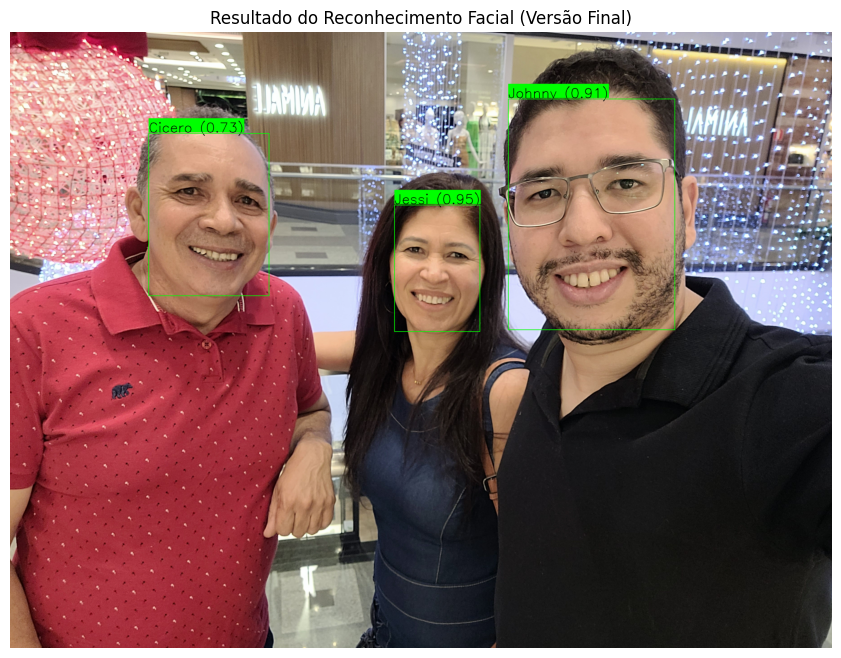

In [6]:
# ===================================================================
#        ETAPA FINAL: PIPELINE COMPLETO (VERSÃO FINAL)
# ===================================================================
# Melhorias:
# 1. Visualização com fundo sólido para o texto.
# 2. Lógica de limiar de confiança para RECONHECIMENTO ("Desconhecidos").
# 3. Lógica de limiar de confiança para DETECÇÃO (evitar "rostos fantasmas").
# ===================================================================

# --- 1. Importações e Carregamento dos Componentes ---
import cv2
import numpy as np
import joblib
from PIL import Image
import tensorflow as tf
from mtcnn.mtcnn import MTCNN
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
from tensorflow.keras.applications import EfficientNetV2B0
import matplotlib.pyplot as plt

print("Carregando todos os componentes do sistema...")
# ... (código de carregamento dos modelos)
detector = MTCNN()
INPUT_SIZE = 224
model_embedding = EfficientNetV2B0(weights='imagenet', include_top=False, pooling='avg', input_shape=(INPUT_SIZE, INPUT_SIZE, 3))
model_svm = joblib.load('/kaggle/working/svm_classifier.pkl')
label_encoder = joblib.load('/kaggle/working/label_encoder.pkl')
print("Todos os componentes foram carregados com sucesso.")


# --- 2. Carregar Imagem e Definir Limiares ---
caminho_imagem_teste = '/kaggle/input/familiapassosgaldino/familia.jpg' 
imagem_teste = cv2.imread(caminho_imagem_teste)
imagem_rgb = cv2.cvtColor(imagem_teste, cv2.COLOR_BGR2RGB)
imagem_desenho = imagem_teste.copy()

# Nossos dois filtros de qualidade:
# Limiar para a DETECÇÃO: Quão confiante o MTCNN deve estar de que algo é um rosto?
limiar_deteccao = 0.95 # <-- NOVO FILTRO! (Valor sugerido: entre 0.90 e 0.99)

# Limiar para o RECONHECIMENTO: Se for um rosto, quão confiante o SVM deve estar sobre quem é a pessoa?
limiar_reconhecimento = 0.70


# --- 3. Detecção e Reconhecimento com a Nova Lógica ---
print("Detectando e reconhecendo faces...")
resultados = detector.detect_faces(imagem_rgb)
print(f"MTCNN encontrou {len(resultados)} potenciais faces.")

# Loop para cada face detectada (com a visualização de texto corrigida)
for resultado in resultados:
    if resultado['confidence'] < limiar_deteccao:
        continue

    x1, y1, largura, altura = resultado['box']
    x1, y1 = abs(x1), abs(y1)
    x2, y2 = x1 + largura, y1 + altura
    
    # ... (código de predição continua exatamente o mesmo) ...
    face = imagem_rgb[y1:y2, x1:x2]
    imagem_face = Image.fromarray(face).resize((INPUT_SIZE, INPUT_SIZE))
    face_array = np.asarray(imagem_face)
    face_expandido = np.expand_dims(face_array.astype('float32'), axis=0)
    face_processado = preprocess_input(face_expandido)
    embedding = model_embedding.predict(face_processado, verbose=0)[0]
    embedding = np.expand_dims(embedding, axis=0)
    predicao_numerica = model_svm.predict(embedding)
    probabilidades = model_svm.predict_proba(embedding)
    confianca_reconhecimento = probabilidades[0][predicao_numerica[0]]
    
    if confianca_reconhecimento >= limiar_reconhecimento:
        nome_previsto = label_encoder.inverse_transform(predicao_numerica)[0]
        cor_retangulo = (0, 255, 0) # Verde para conhecidos
    else:
        nome_previsto = "Desconhecido"
        cor_retangulo = (0, 0, 255) # Vermelho para desconhecidos

    # =======================================================================
    #               *** AJUSTES NA VISUALIZAÇÃO ABAIXO ***
    # =======================================================================
    
    # Parâmetros de texto para facilitar o ajuste
    texto = f"{nome_previsto} ({confianca_reconhecimento:.2f})"
    fonte = cv2.FONT_HERSHEY_SIMPLEX
    escala_fonte = 2 # <-- Pode aumentar ou diminuir este valor
    espessura_fonte = 2 # <-- Pode aumentar para deixar a letra mais "grossa"
    cor_texto = (0, 0, 0) # Branco, para bom contraste com verde/vermelho
    padding = 5 # Um pequeno espaço extra

    # Calcula o tamanho exato do texto para desenhar o fundo
    (largura_texto, altura_texto), baseline = cv2.getTextSize(texto, fonte, escala_fonte, espessura_fonte)
    
    # Coordenadas do retângulo de fundo
    y2_fundo = y1 - padding
    x2_fundo = x1 + largura_texto
    y1_fundo = y1 - altura_texto - baseline - padding

    # Desenha o retângulo de fundo para o texto
    cv2.rectangle(imagem_desenho, (x1, y1_fundo), (x2_fundo, y2_fundo), cor_retangulo, -1)
    
    # Desenha o texto sobre o fundo
    cv2.putText(imagem_desenho, texto, (x1, y1 - padding), fonte, escala_fonte, cor_texto, espessura_fonte)
    
    # Desenha o retângulo ao redor da face
    cv2.rectangle(imagem_desenho, (x1, y1), (x2, y2), cor_retangulo, 2)
    
    print(f"  - Rosto VÁLIDO processado: {nome_previsto} com confianca {confianca_reconhecimento:.2f}")

    # --- 4. Exibir o Resultado Final ---
print("\nExibindo resultado final...")
imagem_final_rgb = cv2.cvtColor(imagem_desenho, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(imagem_final_rgb)
plt.title("Resultado do Reconhecimento Facial (Versão Final)")
plt.axis('off')
plt.show()